# Compare the Fitness of Agents for Different Parameterizations

**Objective**: Under which parameterization is each agents exploration strategy optimal?

| Agent    | Parameter      |
| ------------- | ------------- |
| Reservoir | $\sigma$ |
| Lévy | $\mu$ |
| Exponential | $\alpha$ |

In [1]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params, agent_classes
from simulation import Simulation
from tqdm import tqdm
from agent import ReservoirAgent, LévyAgent, ExponentialAgent, BallisticAgent, BrownianAgent
import matplotlib.pyplot as plt
from multiprocessing import Pool
from config import DATA_PATH, MAX_PROCESSES
from pathlib import Path
import pickle

params = Params.from_json('parameters.json')
params.save = False
folder = 'parameters'
path = Path(DATA_PATH) / folder
path.mkdir(parents=True, exist_ok=True)
data = {}

print(vars(params))

{'agent': <class 'agent.ReservoirAgent'>, 'eat_radius': 0.5, 'velocity': 1, 'perception_radius': 0.5, 'mu': 2, 'alpha': 1, 'num_food': 100, 'size': 200, 'border_buffer': 5, 'food_buffer': 2, 'empty': False, 'resetting_boundary': True, 'seed': 34, 'population_size': 50, 'elite_fraction': 0.4, 'mutation_fraction': 0.4, 'mutation_rate': 0.1, 'mutation_strength': 0.1, 'tolerance': 0.1, 'total_time': 999, 'delta_t': 1, 'num_epochs': 1, 'iterations_per_epoch': 20, 'intervall_save': 5, 'save': False, 'num_neurons': 1000, 'burn_in_time': 100, 'mean': 0, 'standard_deviation': 0.032, 'evolve': False, 'simulation_steps': 1000}


# Reservoir Agent

Note: Computing the reservoir activity over time is computationally expensive and may use all cores, so multiprocessing is not worth it for reservoir agents. \
Advice: limit population size to 50 and iterations_per_epoch to 10 if you want the reservoir agents to finish in reasonable time.

In [2]:
params.type = 'reservoir'
params.agent = ReservoirAgent
std_range = list(np.arange(0.02, 0.05, 0.0005))
reservoir_sizes = [1000]

for size in reservoir_sizes:
    params.num_neurons = size
    fitness_values = []
    
    for std in tqdm(std_range, position=0):
        params.standard_deviation = std
        sim = Simulation(params, params.agent)
        fitness_values.append(np.mean(sim.run(folder), axis=(0,1)))
    
    data[params.type + '_' + str(size)] = fitness_values

100%|██████████| 60/60 [4:51:48<00:00, 291.81s/it]  


# Lévy Agent

In [3]:
params.type = 'levy'
params.agent = LévyAgent
mu_range = list(np.arange(1, 5, 0.2))

def run_simulation(mu):
    params.mu = mu
    sim = Simulation(params, agent_classes[params.type])
    return np.mean(sim.run(folder))

tasks = []
for mu in mu_range:
    tasks.append(mu)

with Pool(MAX_PROCESSES) as pool:
    results = list(tqdm(pool.imap(run_simulation, tasks), total=len(tasks)))

data[params.type] = results

100%|██████████| 20/20 [15:44<00:00, 47.23s/it]  


# Exponential Agent

In [4]:
params.type = 'exponential'
params.agent = ExponentialAgent
alpha_range = list(np.arange(0.1, 2, 0.1))

def run_simulation(alpha):
    params.alpha = alpha
    sim = Simulation(params, agent_classes[params.type])
    return np.mean(sim.run(folder))

tasks = []
for alpha in alpha_range:
    tasks.append(alpha)

with Pool(MAX_PROCESSES) as pool:
    results = list(tqdm(pool.imap(run_simulation, tasks), total=len(tasks)))

data[params.type] = results

100%|██████████| 19/19 [15:17<00:00, 48.28s/it]  


# Brownian Agent

In [5]:
params.type = 'brownian'
params.agent = BrownianAgent

sim = Simulation(params, params.agent)

data[params.type] = np.mean(sim.run(folder))

# Ballistic Agent

In [6]:
params.type = 'ballistic'
params.agent = BallisticAgent

sim = Simulation(params, params.agent)

data[params.type] = np.mean(sim.run(folder))

In [7]:
with open(path / 'data.pkl', 'wb') as f:
    pickle.dump(data, f)

# Visualize

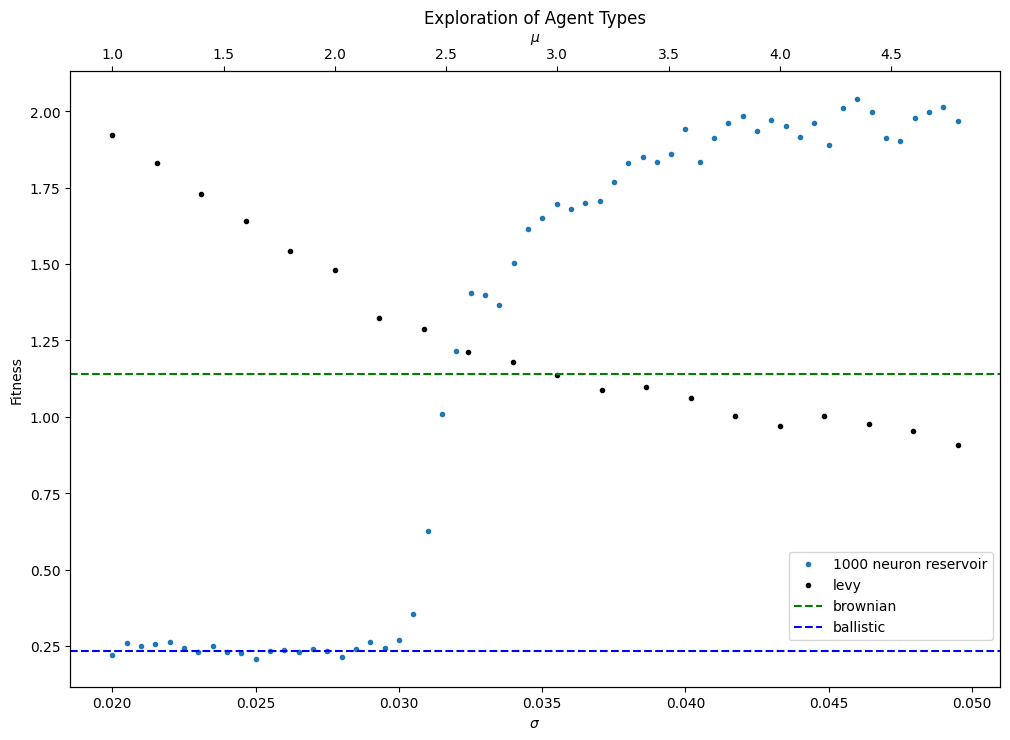

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 8))

with open(path / 'data.pkl', 'rb') as f:
    data = pickle.load(f)

# first x-axis for reservoir
for size in reservoir_sizes:
    ax1.plot(std_range, data['reservoir_' + str(size)], '.', label=f'{size} neuron reservoir')
ax1.set_xlabel(r'$\sigma$')
ax1.set_ylabel('Fitness')
ax1.set_title('Exploration of Agent Types')

# second x-axis for levy
ax2 = ax1.twiny()
ax2.plot(mu_range, data['levy'], '.', label='levy', color='black')
ax2.set_xlabel(r'$\mu$')

# # third x-axis for exponential
# ax3 = ax1.twiny()
# ax3.spines["top"].set_position(("axes", 1.1))  # offset third axis
# ax3.plot(alpha_range, data['exponential'], '.', label='exponential', color='orange')
# ax3.set_xlabel(r'$\alpha$')
# ax3.xaxis.set_label_position('top')

# horizontal lines for brownian and ballistic
plt.axhline(y=data['brownian'], color='g', linestyle='--', label='brownian')
plt.axhline(y=data['ballistic'], color='b', linestyle='--', label='ballistic')

# combined legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1, 0.23))
# add to combined legends
# lines3, labels3 = ax3.get_legend_handles_labels()
# ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='lower right')

plt.savefig(path / 'fitness.svg', format='svg')